## Step 1: Data acquisition

In [192]:
import json

In [193]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [194]:
desktop_params_pageviews = {
    "project" : "en.wikipedia.org",
    "access" : "desktop",
    "agent" : "user",
    "granularity" : "monthly",
    "start" : "2001010100",
    # for end use 1st day of month following final month of data
    "end" : '2021090100' 
}

mobile_params_pageviews = {
    "project" : "en.wikipedia.org",
    "access" : "mobile-web",
    "agent" : "user",
    "granularity" : "monthly",
    "start" : "2001010100",
    # for end use 1st day of month following final month of data
    "end" : '2021090100' 
}

app_params_pageviews = {
    "project" : "en.wikipedia.org",
    "access" : "mobile-app",
    "agent" : "user",
    "granularity" : "monthly",
    "start" : "2001010100",
    # for end use 1st day of month following final month of data
    "end" : '2021090100' 
}

desktop_params_legacy = {
    "project" : "en.wikipedia.org",
    "access-site" : "desktop-site",
    "granularity" : "monthly",
    "start" : "2001010100",
    # for end use 1st day of month following final month of data
    "end" : '2021090100' 
}

mobile_params_legacy = {
    "project" : "en.wikipedia.org",
    "access-site" : "mobile-site",
    "granularity" : "monthly",
    "start" : "2001010100",
    # for end use 1st day of month following final month of data
    "end" : '2021090100' 
}

headers = {
    'User-Agent': 'https://github.com/DhruvRelwani',
    'From': 'drelwani@uw.edu'
}

In [195]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

We will now be utilizing the JSON template above and the api_call method to acquire our data about page visits on English Wikipedia between December 2007 and August 2021. We will collect this data through both the APIs available to us (Legacy PageCount and PageViews). Finally, we will store this data in 5 CSV files.

In [196]:
desktop_params_pageviews_apiresult = api_call(endpoint_pageviews, desktop_params_pageviews)
mobile_params_pageviews_apiresult = api_call(endpoint_pageviews, mobile_params_pageviews)
app_params_pageviews_apiresult = api_call(endpoint_pageviews, app_params_pageviews)

In [197]:
with open('./source_data_files/pageviews_desktop-site_200712-202108.json', 'w', encoding='utf-8') as file:
    json.dump(desktop_params_pageviews_apiresult, file, ensure_ascii = False)

with open('./source_data_files/pageviews_mobile-web_200712-202108.json', 'w', encoding='utf-8') as file:
    json.dump(mobile_params_pageviews_apiresult, file, ensure_ascii = False)

with open('./source_data_files/pageviews_mobile-app_200712-202108.json', 'w', encoding='utf-8') as file:
    json.dump(app_params_pageviews_apiresult, file, ensure_ascii = False)

In [198]:
desktop_params_legacy_apiresult = api_call(endpoint_legacy, desktop_params_legacy)
mobile_params_legacy_apiresult = api_call(endpoint_legacy, mobile_params_legacy)

In [199]:
with open('./source_data_files/legacy-pagecounts_desktop-site_200712-201607.json', 'w', encoding='utf-8') as file:
    json.dump(desktop_params_legacy_apiresult, file, ensure_ascii = False)

with open('./source_data_files/legacy-pagecounts_mobile-site_200712-201607.json', 'w', encoding='utf-8') as file:
    json.dump(mobile_params_legacy_apiresult, file, ensure_ascii = False)

## Step 2: Data processing

In [200]:
import pandas as pd

In [201]:
def data_cleaning(df, api_type):
    df['year'] = df['timestamp'].str.slice(start = 0, stop = 4).astype(int)
    df['month'] = df['timestamp'].str.slice(start = 4, stop = 6).astype(int)
    if api_type == "legacy":
        result = df[['year', 'month', 'count']]
    else:
        result = df[['year', 'month', 'views']]
    return result

With the help of our data_cleaning method, we will now generate our pandas dataframe tables from the CSV files. We will select only the columns that we need and rename them for our understanding. Finally, we will be performing several joins on these tables (on the year and month columns) to generate aggregated tables.

In [202]:
# Pageviews API
df_pageviews_desktop = data_cleaning(pd.json_normalize(desktop_params_pageviews_apiresult['items']), "pageviews")
df_pageviews_mobile = data_cleaning(pd.json_normalize(mobile_params_pageviews_apiresult['items']), "pageviews")
df_pageviews_app = data_cleaning(pd.json_normalize(app_params_pageviews_apiresult['items']), "pageviews")
df_pageviews_desktop

,year,month,views
0,2015,7,4376666686
1,2015,8,4332482183
2,2015,9,4485491704
3,2015,10,4477532755
4,2015,11,4287720220
...,...,...,...
69,2021,4,2882714492
70,2021,5,2824416177
71,2021,6,2505971366
72,2021,7,2765584368


In [203]:
df_pageviews_desktopandmobile = df_pageviews_desktop.merge(df_pageviews_mobile,on=['year','month'],how='outer')
df_pageviews_desktopandmobile = df_pageviews_desktopandmobile.rename(columns={'views_y':'pageviews_mobile','views_x':'pageview_desktop_views'})
df_pageviews_desktopandmobile

,year,month,pageview_desktop_views,pageviews_mobile
0,2015,7,4376666686,3179131148
1,2015,8,4332482183,3192663889
2,2015,9,4485491704,3073981649
3,2015,10,4477532755,3173975355
4,2015,11,4287720220,3142247145
...,...,...,...,...
69,2021,4,2882714492,4596834586
70,2021,5,2824416177,4810094479
71,2021,6,2505971366,4433805793
72,2021,7,2765584368,4617448266


In [204]:
df_pageviews = df_pageviews_desktopandmobile.merge(df_pageviews_app,on=['year','month'],how='outer')
df_pageviews = df_pageviews.rename(columns={'views':'pageviews_app'})
df_pageviews.fillna(0,inplace=True)
df_pageviews

,year,month,pageview_desktop_views,pageviews_mobile,pageviews_app
0,2015,7,4376666686,3179131148,109624146
1,2015,8,4332482183,3192663889,109669149
2,2015,9,4485491704,3073981649,96221684
3,2015,10,4477532755,3173975355,94523777
4,2015,11,4287720220,3142247145,94353925
...,...,...,...,...,...
69,2021,4,2882714492,4596834586,162260497
70,2021,5,2824416177,4810094479,166485079
71,2021,6,2505971366,4433805793,150704624
72,2021,7,2765584368,4617448266,161461155


In [205]:
df_pageviews['pageview_mobile_views'] = df_pageviews['pageviews_app'] + df_pageviews['pageviews_mobile']
df_pageviews['pageview_all_views'] = df_pageviews['pageview_desktop_views'] + df_pageviews['pageview_mobile_views']
df_pageviews_final = df_pageviews[['year', 'month', 'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]
df_pageviews_final

,year,month,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2015,7,7665421980,4376666686,3288755294
1,2015,8,7634815221,4332482183,3302333038
2,2015,9,7655695037,4485491704,3170203333
3,2015,10,7746031887,4477532755,3268499132
4,2015,11,7524321290,4287720220,3236601070
...,...,...,...,...,...
69,2021,4,7641809575,2882714492,4759095083
70,2021,5,7800995735,2824416177,4976579558
71,2021,6,7090481783,2505971366,4584510417
72,2021,7,7544493789,2765584368,4778909421


Here's, the intermediate output of our table generated from only from the pageview API data. Now we will repeat this process for the data acquired from the legacy pagecount data.

In [206]:
# Legacy API
df_pagecount_desktop = data_cleaning(pd.json_normalize(desktop_params_legacy_apiresult['items']), "legacy") 
df_pagecount_mobile = data_cleaning(pd.json_normalize(mobile_params_legacy_apiresult['items']), "legacy")

In [207]:
df_legacy = df_desktop.merge(df_mobile,on=['year','month'],how='left')
df_legacy = df_legacy.rename(columns={'count_y':'pagecount_mobile_views','count_x':'pagecount_desktop_views'})
df_legacy.fillna(0, inplace = True)
df_legacy

,year,month,pagecount_desktop_views,pagecount_mobile_views
0,2007,12,2998331524,0.000000e+00
1,2008,1,4930902570,0.000000e+00
2,2008,2,4818393763,0.000000e+00
3,2008,3,4955405809,0.000000e+00
4,2008,4,5159162183,0.000000e+00
...,...,...,...,...
100,2016,4,5572235399,3.301385e+09
101,2016,5,5330532334,3.418436e+09
102,2016,6,4975092447,3.372618e+09
103,2016,7,5363966439,3.500661e+09


In [208]:
df_legacy_final =  df_legacy
df_legacy_final['pagecount_all_views']=df_legacy['pagecount_mobile_views']+df_legacy['pagecount_desktop_views']
all_legacy_col = df_legacy_final.pop("pagecount_all_views")
df_legacy_final.insert(2, "pagecount_all_views", all_legacy_col)
df_legacy_final

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views
0,2007,12,2.998332e+09,2998331524,0.000000e+00
1,2008,1,4.930903e+09,4930902570,0.000000e+00
2,2008,2,4.818394e+09,4818393763,0.000000e+00
3,2008,3,4.955406e+09,4955405809,0.000000e+00
4,2008,4,5.159162e+09,5159162183,0.000000e+00
...,...,...,...,...,...
100,2016,4,8.873621e+09,5572235399,3.301385e+09
101,2016,5,8.748968e+09,5330532334,3.418436e+09
102,2016,6,8.347711e+09,4975092447,3.372618e+09
103,2016,7,8.864628e+09,5363966439,3.500661e+09


In [209]:
#Merging both the API type tables
final_table = df_legacy_final.merge(df_pageviews_final,on=['year','month'],how='outer')
final_table.fillna(0, inplace = True)
final_table.to_csv('./en-wikipedia_traffic_200712-202108.csv',index = False)
final_table

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,2008,1,4.930903e+09,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,2008,2,4.818394e+09,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,2008,3,4.955406e+09,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
4,2008,4,5.159162e+09,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
160,2021,4,0.000000e+00,0.000000e+00,0.0,7.641810e+09,2.882714e+09,4.759095e+09
161,2021,5,0.000000e+00,0.000000e+00,0.0,7.800996e+09,2.824416e+09,4.976580e+09
162,2021,6,0.000000e+00,0.000000e+00,0.0,7.090482e+09,2.505971e+09,4.584510e+09
163,2021,7,0.000000e+00,0.000000e+00,0.0,7.544494e+09,2.765584e+09,4.778909e+09


## Step 3: Analysis

In [210]:
import matplotlib.pyplot as plt
import numpy as np

We will be setting a few parameters which will help us view the timeseries graph according the scale of our choice.

In [211]:
final_table['date'] = pd.to_datetime(final_table['year']*100 + final_table['month'], format = '%Y%m')
final_table.replace(0, np.nan, inplace = True)
ylim = np.max(final_table['pagecount_all_views'])*1.03

Text(0, 0.5, 'Page Views (in billions)')

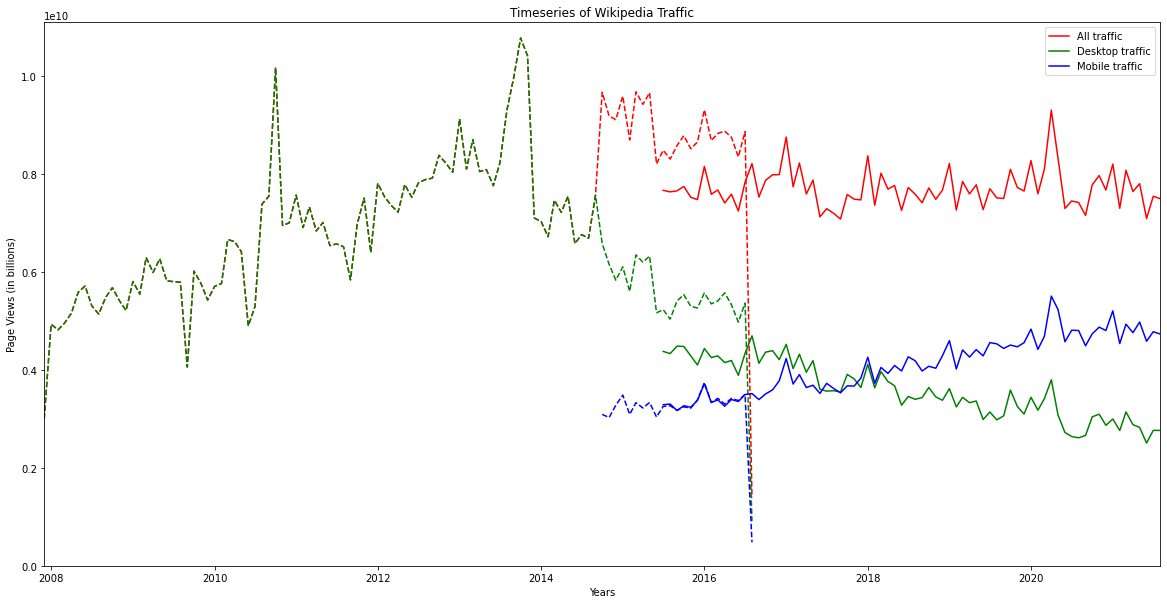

In [212]:
plt.figure(figsize = (20, 10))
plt.plot(final_table['date'],final_table['pagecount_all_views'],c ='red',linestyle = '--')
plt.plot(final_table['date'],final_table['pageview_all_views'],c='red',linestyle = '-',label = 'All traffic')

plt.plot(final_table['date'],final_table['pagecount_desktop_views'],c ='green',linestyle='--')
plt.plot(final_table['date'],final_table['pageview_desktop_views'],c ='green',linestyle='-',label='Desktop traffic')

plt.plot(final_table['date'], final_table['pagecount_mobile_views'],c='blue',linestyle='--')
plt.plot(final_table['date'], final_table['pageview_mobile_views'],c='blue',linestyle ='-',label='Mobile traffic')

plt.legend(fontsize = 10)
plt.title('Timeseries of Wikipedia Traffic')
plt.xlim(min(final_table['date']), max(final_table['date']))
plt.ylim(0, ylim)
plt.xlabel('Years')
plt.ylabel('Page Views (in billions)')

In [215]:
# Fixing the drop in the graph
cutoff_date = max(final_table.loc[pd.notnull(final_table['pagecount_all_views'])]['date'])
final_table.loc[final_table['date']==cutoff_date,['pagecount_desktop_views','pagecount_mobile_views','pagecount_all_views']] = np.nan

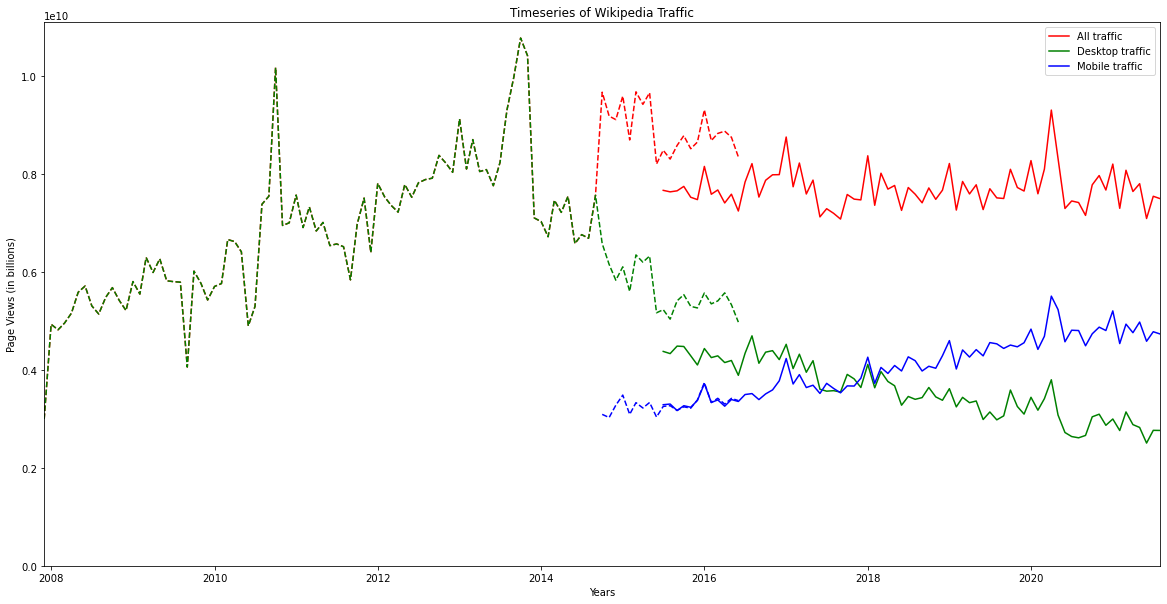

In [217]:
plt.figure(figsize = (20, 10))
plt.plot(final_table['date'],final_table['pagecount_all_views'],c ='red',linestyle = '--')
plt.plot(final_table['date'],final_table['pageview_all_views'],c='red',linestyle = '-',label = 'All traffic')

plt.plot(final_table['date'],final_table['pagecount_desktop_views'],c ='green',linestyle='--')
plt.plot(final_table['date'],final_table['pageview_desktop_views'],c ='green',linestyle='-',label='Desktop traffic')

plt.plot(final_table['date'], final_table['pagecount_mobile_views'],c='blue',linestyle='--')
plt.plot(final_table['date'], final_table['pageview_mobile_views'],c='blue',linestyle ='-',label='Mobile traffic')

plt.legend(fontsize = 10)
plt.title('Timeseries of Wikipedia Traffic')
plt.xlim(min(final_table['date']), max(final_table['date']))
plt.ylim(0, ylim)
plt.xlabel('Years')
plt.ylabel('Page Views (in billions)')
plt.savefig('./TimeSeries_en-wikipedia_traffic_200712-202108')

The above timeseries graph now represents the page views/ traffic on English Wikipedia from December 2007 to August 2021.